In [1]:
import seaborn as sns
sns.set()

# The New York Social Graph


[New York Social Diary](https://www.newyorksocialdiary.com/) provides a
fascinating lens onto New York's socially well-to-do.  The data forms a natural social graph for New York's social elite.  Take a look at this page of a recent [To Love Unconditionally](https://www.newyorksocialdiary.com/to-love-unconditionally/). 

You will notice the photos have carefully annotated captions labeling those that appear in the photos.  We can think of this as implicitly implying a social graph: there is a connection between two individuals if they appear in a picture together.

For this project, we will assemble the social graph from photo captions for parties.  Using this graph, we can make guesses at the most popular socialites, the most influential people, and the most tightly coupled pairs.

We will attack the project in three phases:
1. Get a list of all the photo pages to be analyzed. 
2. Get all captions in each party, Parse all of the captions and extract guests' names.
3. Assemble the graph, analyze the graph and answer the questions

## Phase One (20 pts)


The first step is to crawl the data.  We want photos from parties on or before December 1st, 2014.  Go to the [Party Pictures Archive](https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures) to see a list of (party) pages.  We want to get the url for each party page, along with its date.

Here are some packages that you may find useful.  You are welcome to use others, if you prefer.

In [1]:
import calendar
import os
import time
import requests
import dill
import re
import csv
import math
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import itertools
import ast
from bs4 import BeautifulSoup
from datetime import datetime
import graph_tool as gt
from graph_tool.all import *
import numpy as np
import scipy
import lxml

We recommend using Python [Requests](http://docs.python-requests.org/en/master/) to download the HTML pages, and [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/) to process the HTML.  Let's start by getting the [first page](https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures).

In [2]:
page = requests.get("https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures")

Now, we process the text of the page with BeautifulSoup.

In [4]:
soup = BeautifulSoup(page.text, "lxml")

This page has links to 50 party pages. Look at the structure of the page and determine how to isolate those links.  Your browser's developer tools (usually `Cmd`-`Option`-`I` on Mac, `Ctrl`-`Shift`-`I` on others) offer helpful tools to explore the structure of the HTML page.

Once you have found a pattern, use BeautifulSoup's [select](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#css-selectors) or [find_all](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#find) methods to get those elements.

In [3]:
def get_links(response):
    soup = BeautifulSoup(response.text, "lxml")
    target_elements = soup.find_all('div', attrs={'class': 'views-row'})
    elements = []
    for el in target_elements:
        if el: elements.append(el)
    return elements

In [6]:
links = get_links(page)

There should be 50 per page.

In [7]:
len(links) == 50

True

Let's take a look at that first link.  Figure out how to extract the URL of the link, as well as the date.  You probably want to use `datetime.strptime`.  See the [format codes for dates](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior) for reference.

In [ ]:
"/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures/2015/grand-finale-of-the-hampton-classic-horse-show">Grand Finale of the Hampton Classic Horse Show</a>

In [8]:
link = links[0]
# Check that the title and date match what you see visually.

For purposes of code reuse, let's put that logic into a function.  It should take the link element and return the URL and date parsed from it.

In [4]:
#4p
def get_link_date(el):
    try:
        properties = el.select('span', attrs={'class': 'views-field-created'})
        url_pattern = re.compile(r'(\/web\/\d{14}\/http.+?)"')
        date_pattern = re.compile(r'([A-Za-z]+ \d{1,2}, \d{4})')
        link = url_pattern.search(str(properties[0])).group(1)
        full_link = "https://web.archive.org" + link
        date = date_pattern.search(str(properties[2])).group()

        if full_link and date:
            return date, full_link
        else:
            return None, None
    except Exception as e:
        print(f"Error in getting link data: {e}")
        return None, None

You may want to check that it works as you expected.

Once that's working, let's write another function to parse all of the links on a page.  Thinking ahead, we can make it take a Requests [Response](https://requests.readthedocs.io/en/master/api/#requests.Response) object and do the BeautifulSoup parsing within it.

In [5]:
#4p
def get_links(response):
    soup = BeautifulSoup(response.text, "lxml")
    target_elements = soup.find_all('div', attrs={'class': 'views-row'})
    elements = []
    for el in target_elements:
        if el: elements.append(el)
    return elements

If we run this on the previous response, we should get 50 pairs.

In [11]:
# These should be the same links from earlier
len(get_links(page)) == 50

True

But we only want parties with dates on or before the first of December, 2014.  Let's write a function to filter our list of dates to those at or before a cutoff.  Using a keyword argument, we can put in a default cutoff, but allow us to test with others.

In [6]:
#2p
def filter_by_date(links, cutoff=datetime(2014, 12, 1)):
    filtered_links = []

    for link in links:
        date, url = get_link_date(link)
        date = datetime.strptime(date, "%B %d, %Y")
        if date and date <= cutoff:
            filtered_links.append([url, date])

    return filtered_links

With the default cutoff, there should be no valid parties on the first page.  Adjust the cutoff date to check that it is actually working.

In [13]:
# Double check the dates are being extracted correctly
len(filter_by_date(get_links(page), datetime(2015, 12, 1))) == 50

True

**<span style="color:red">!!! We are now ready to retrieve all of the party URLs. However, for this assignment you won’t need to collect the full set, as data will be provided to you. This step is included primarily for your learning.</span>** 

Click through a few of the index pages to determine how the URL changes.  Figure out a strategy to visit all of them.

HTTP requests are generally IO-bound.  This means that most of the time is spent waiting for the remote server to respond.  If you use `requests` directly, you can only wait on one response at a time.  [requests-futures](https://github.com/ross/requests-futures) lets you wait for multiple requests at a time.  You may wish to use this to speed up the downloading process.

In [18]:
def get_next_page(response):
    soup = BeautifulSoup(response.text, "lxml")
    link = soup.find("a", title="Go to next page")
    href = None
    if link: href = link.get("href")
    if href: return "https://web.archive.org" + href
    return href

def scrape():
    url = "https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures"
    party_links = []
    counter = 0
    session = requests.Session()

    while url:
        try:
            counter += 1
            print(f"Scraping Page: {counter}")
            print(f"Number of links collected: {len(party_links)}")

            response = session.get(url, timeout=20)
            time.sleep(1)
            links = get_links(response)

            cutoff = datetime(2014, 12, 1) 
            filtered_links = filter_by_date(links, cutoff=cutoff)

            for link in filtered_links:
                if link not in party_links:
                    party_links.append(link)

            url = get_next_page(response)
        except Exception as e:
            print(f"Error getting page {counter}: {e}")
            break

    print(f"Total links collected: {len(party_links)}")

    return party_links

link_list = scrape()

Scraping Page: 1
Number of links collected: 0
Scraping Page: 2
Number of links collected: 0
Scraping Page: 3
Number of links collected: 20
Scraping Page: 4
Number of links collected: 70
Scraping Page: 5
Number of links collected: 120
Scraping Page: 6
Number of links collected: 170
Scraping Page: 7
Number of links collected: 220
Scraping Page: 8
Number of links collected: 270
Scraping Page: 9
Number of links collected: 320
Scraping Page: 10
Number of links collected: 370
Scraping Page: 11
Number of links collected: 420
Scraping Page: 12
Number of links collected: 470
Scraping Page: 13
Number of links collected: 520
Scraping Page: 14
Number of links collected: 570
Scraping Page: 15
Number of links collected: 620
Scraping Page: 16
Number of links collected: 670
Scraping Page: 17
Number of links collected: 720
Scraping Page: 18
Number of links collected: 770
Scraping Page: 19
Number of links collected: 820
Scraping Page: 20
Number of links collected: 870
Scraping Page: 21
Number of links c

In the end, you should have 1193 parties.

In [19]:
# Make sure you are using the same /web/stringofdigits/... for each page
# This is to prevent the archive from accessing later copies of the same page
# If you are off by a just a few, that can be the archive misbehaving
print(len(link_list) == 1193)
print(len(link_list) - 1193 <= 5)
print("Close enough!")

False
True
Close enough!


In case we need to restart the notebook, we should save this information to a file.  There are many ways you could do this; here's one using `dill`.

In [20]:
dill.dump(link_list, open('nysd-links.pkd', 'wb'))

To restore the list, we can just load it from the file.  When the notebook is restarted, you can skip the code above and just run this command.

In [7]:
link_list = dill.load(open('nysd-links.pkd', 'rb'))

Now, let’s carry out some preliminary analysis using the provided Parties_Data.csv file. Answer Question 1 and Question 2 using the full dataset

### Question 1: In which month did most of the parties occur? 
hint: we are interested in monthly aggregates(5 p). **See answer below code/graphs below.**
### Question 2: What is the overall trend of parties from 2007 to 2014? (5 p)
hint: We are interested in a time series visualization. You may apply a moving average to smooth the data and highlight the overall trend.
Use visualizations to answer the two questions above. Ensure that you interpret your plots thoroughly. **See answer below code/graphs below.**

In [22]:
def plot_parties_by_month(dates):
    df = pd.DataFrame({'date': dates})
    df['month_number'] = df['date'].dt.month
    df['month_name'] = df['date'].dt.month_name()

    amounts = df.groupby('month_number').size().reindex(range(1, 13), fill_value=0)
    month_names = [calendar.month_name[i] for i in range(1, 13)]
    amounts.index = month_names

    max_month = amounts.idxmax()
    max_count = int(amounts.max())
    total = int(amounts.sum())
    #debug percent
    percent = max_count / total * 100 if total > 0 else 0

    fig, ax = plt.subplots(figsize=(11, 5))
    bars = ax.bar(amounts.index, amounts.values, width=0.7)

    #enphisize max month
    max_idx = month_names.index(max_month)
    bars[max_idx].set_edgecolor('black')
    bars[max_idx].set_linewidth(2)

    #add labels
    for rect, val in zip(bars, amounts.values):
        ax.text(rect.get_x() + rect.get_width() / 2, val + 0.5, str(int(val)),
                ha='center', va='bottom', fontsize=9)

    ax.set_title("Parties by Month (Aggregated over 2007-2014)")
    ax.set_xlabel("Month")
    ax.set_ylabel("Number of Parties")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_party_trend(dates):
    df = pd.DataFrame(dates, columns=['date'])
    #lets group by dates and count each group
    df = df.groupby(pd.Grouper(key='date', freq='ME')).size().reset_index(name='count')
    df = df.sort_values('date')
    df['moving_avg'] = df['count'].rolling(window=12, center=True).mean()

    plt.figure(figsize=(12, 6))
    plt.plot(df['date'], df['count'], alpha=0.5, label="Counts by Month")
    plt.plot(df['date'], df['moving_avg'], color="blue", linewidth=2, label="Moving 12-month Average")
    plt.title("Party Trend (2007–2014)")
    plt.xlabel("Date")
    plt.ylabel("Number of Parties")
    plt.legend()
    plt.show()

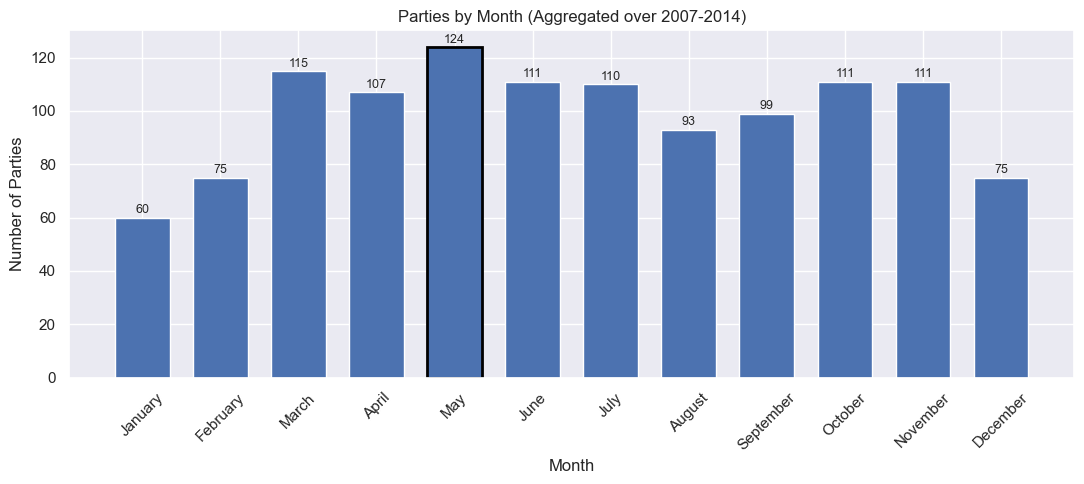

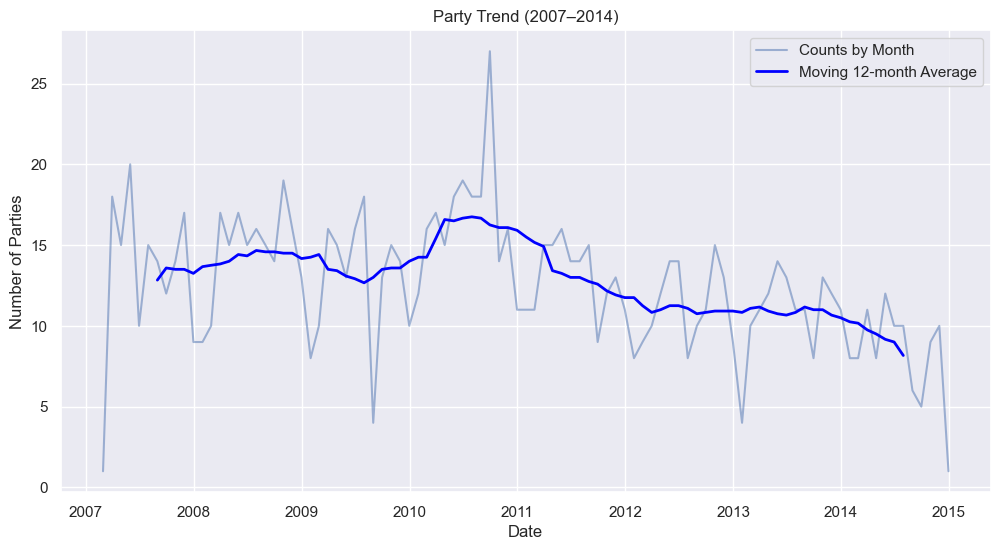

In [23]:
##Plots for Q1 & Q2

dates = []
for link in link_list:
    dates.append(link[1])

plot_parties_by_month(dates)

plot_party_trend(dates)

#### Q1:
**MAY!** May had a higher number of parties than any other month (124) from 2007-2014.  
#### Q2:
The number of parties seemed to peak in 2010/2011, and then steadily decrease in the following years. There is a cyclical nature to the trend of parties from year to year, typically peaking in the summer months and again at the end of the year around November. Whenever there are months that seem to have a large number of parties the following month drops off. This makes sense as to not burn everyone out and also give time to plan between events!  

## Phase Two (40 pts)


In this phase, we concentrate on getting the names out of captions for a given page.  We'll start with [the benefit cocktails and dinner](https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures/2015/celebrating-the-neighborhood) for [Lenox Hill Neighborhood House](http://www.lenoxhill.org/), a neighborhood organization for the East Side.

Take a look at that page.  Note that some of the text on the page is captions, but others are descriptions of the event.  Determine how to select only the captions.

In [8]:
#5p
def fetch_with_retry(session, url, retries=5, delay=5):
    for i in range(retries):
        try:
            return session.get(url, timeout=45, allow_redirects=True)
        except requests.exceptions.RequestException as e:
            print(f"Attempt {i+1}/{retries} failed: {e}")
            time.sleep(delay * (i+1))
    return None

captions = []
link = "https://web.archive.org/web/20151114014941/http://www.newyorksocialdiary.com/party-pictures/2015/celebrating-the-neighborhood"
session = requests.Session()
response = fetch_with_retry(session, link)
if response is None: raise Exception(f"No Response")
soup = BeautifulSoup(response.text, "lxml")
tags = soup.find_all(attrs={'class': 'photocaption'})
for tag in tags:
    text = tag.string
    captions.append(text)

By our count, there are about 110.  But if you're off by a couple, you're probably okay.

In [26]:
# These are for the specific party referenced in the text
abs(len(captions) - 110) < 5

True

Let's encapsulate this in a function.  As with the links pages, we want to avoid downloading a given page the next time we need to run the notebook.  While we could save the files by hand, as we did before, a checkpoint library like [ediblepickle](https://pypi.python.org/pypi/ediblepickle/1.1.3) can handle this for you.  (Note, though, that you may not want to enable this until you are sure that your function is working.)

You should also keep in mind that HTTP requests fail occasionally, for transient reasons.  You should plan how to detect and react to these failures.   The [retrying module](https://pypi.python.org/pypi/retrying) is one way to deal with this.

In [9]:
#5p
def get_captions(path):
    captions = []
    session = requests.Session()
    session.headers.update({
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
        'Accept-Language': 'en-US,en;q=0.5',
        'Accept-Encoding': 'gzip, deflate',
        'Connection': 'keep-alive',
        'Upgrade-Insecure-Requests': '1',
    })
    print(f"Fetching {link}")
    try:
        response = fetch_with_retry(session, link)
        if response is None: raise Exception(f"No Response")
        soup = BeautifulSoup(response.text, "lxml")
        tags = soup.find_all(attrs={'class': 'photocaption'})
        for tag in tags:
            text = tag.string
            captions.append(text)
        return captions
    except Exception as e:
        print(f"Fetching Failed {link}: {e}")
        return captions

This should get the same captions as before.

In [28]:
# This cell is expecting get_captions to return a list of the captions themselves
# Other routes to a solution might need to adjust this cell a bit
captions == get_captions("/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures/2015/celebrating-the-neighborhood")

Fetching https://web.archive.org/web/20151114014941/http://www.newyorksocialdiary.com/party-pictures/2015/celebrating-the-neighborhood


True

**<span style="color:red">!!! As in the previous phase, writing the function to scrape the captions is sufficient. You don’t need to collect captions for all parties. For the next part of the project (name extraction), you can use the provided dataset.</span>** 

### Names Extraction

Now that we have some sample captions, let's start parsing names out of those captions.  There are many ways of going about this, and we leave the details up to you.  Some issues to consider:

  1. Long captions are often not lists of people.  The cutoff is subjective, but for grading purposes, *set that cutoff at 250 characters*.
  2. You will want to separate the captions based on various forms of punctuation.  Try using `re.split`, which is more sophisticated than `string.split`. **Note: Use regex exclusively for name parsing.**
  3. You might find a person named "ra Lebenthal".  There is no one by this name.  Can you spot what's happening here?
  4. This site is pretty formal and likes to say things like "Mayor Michael Bloomberg" after his election but "Michael Bloomberg" before his election.  Can you find other titles that are being used?  They should probably be filtered out because they ultimately refer to the same person: "Michael Bloomberg."
  5. There is a special case you might find where couples are written as eg. "John and Mary Smith". You will need to write some extra logic to make sure this properly parses to two names: "John Smith" and "Mary Smith".
  6. When parsing names from captions, it can help to look at your output frequently and address the problems that you see coming up, iterating until you have a list that looks reasonable. Because we can only asymptotically approach perfect identification and entity matching, we have to stop somewhere.
  
**Questions worth considering:**
  1. Who is Patrick McMullan and should he be included in the results? How would you address this?
  2. What else could you do to improve the quality of the graph's information?

Taking into account the challenges mentioned above, as well as any others you may encounter, define an algorithm using different regex rules and logic. Then, test your algorithm on your sample page [the benefit cocktails and dinner](https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures/2015/celebrating-the-neighborhood)
regex101.com is a wondeful resource to learn and test your logics on a sample text.

Once you feel that your algorithm is working well on these captions of this page, parse all of the captions and extract all the names mentioned. Sort them alphabetically, by first name, and return the first hundred. 

In [10]:
#5p

# Parses a caption into names
def parse_text(text):
    names = []
    """
    group 1 grabs three word names (i.e. Iffie Okoronkwo Aitkenhead)
    group 2 grabs two word names (i.e. Lise Evans)
    group 3 grabs couple names (i.e. Michael and Lise Evans)
    """
    ptn = re.compile(r'((?!\band\b)\w+\s+(?!\band\b)\w+\s+(?!\band\b)\w+(?:\n|,))'
                   r'|((?!\band\b)\b\w+\b\s+(?!\band\b)[\w+-]+\b)'
                   r'|(\w+(?:,\s+|\s+)and\s+\w+\s+\w+\b)')
    if text is None: return []
    matches = re.findall(ptn, text)
    for match in matches:
        if match[0] != '' and not is_junk(match[0]):
            cleaned = re.sub(r"[\n\r,]", "", match[0])
            cleaned = re.sub(r"\s\s+", " ", cleaned)
            names.append(cleaned)
        if match[1] != '':
            if not is_junk(match[1]):
                cleaned = re.sub(r"[\n\r,]", "", match[1])
                cleaned = re.sub(r"\s\s+", " ", cleaned)
                names.append(cleaned)
        if match[2] != '' and not is_junk(match[2]):
            try:
                cleaned = re.sub(r"\s\s+", " ", match[2])
                couple = cleaned.split(' and ')
                name1 = couple[0] + ' ' + couple[1].split(' ')[1]
                name2 = couple[1]
                names.append(name1)
                names.append(name2)
            except Exception as e:
                print(f"Expected Couple Name got {match[2]}: {e}")
    return names

# Filters out junk names
def is_junk(name):
    name = str(name)
    '''Spaced for Readability'''
    pattern = re.compile(r'^[a-z].*'
                         r'|[0-9]+'
                         r'|^\w+\s[a-z]+'
                         r'|\w*[A-Z]{2}\w*'
                         r'|\bDinner\b'
                         r'|\bThe\b'
                         r'|\bTheater\b'
                         r'|\bNew\b'
                         r'|\bEstate\b'
                         r'|\bCity\b'
                         r'|\bAnnual\b'
                         r'|\bCocktails\b'
                         r'|\bBoard\b'
                         r'|\bBuilding\b'
                         r'|\bBall\b'
                         r'|\bDance\b'
                         r'|\bBenefit\b'
                         r'|\bMuseum\b'
                         r'|\bGeneration\b'
                         r'|\bHonoring\b'
                         r'|\bCNN\b'
                         r'|\bGala\b'
                         r'|\bParty\b'
                         r'|\bLuncheon\b'
                         r'|\bLunch\b'
                         r'|\bBrunch\b'
                         r'|\bReception\b'
                         r'|\bOpening\b'
                         r'|\bNight\b'
                         r'|\bEvening\b'
                         r'|\bSpring\b'
                         r'|\bSummer\b'
                         r'|\bFall\b'
                         r'|\bAutumn\b'
                         r'|\bWinter\b'
                         r'|\bAnniversary\b'
                         r'|\bBirthday\b'
                         r'|\bFundraiser\b'
                         r'|\bFund\b'
                         r'|\bFoundation\b'
                         r'|\bAwards\b'
                         r'|\bAward\b'
                         r'|\bMasquerade\b'
                         r'|\bConcert\b'
                         r'|\bPerformance\b'
                         r'|\bShow\b'
                         r'|\bExhibition\b'
                         r'|\bExhibit\b'
                         r'|\bPreview\b'
                         r'|\bFestival\b'
                         r'|\bFair\b'
                         r'|\bArt\b'
                         r'|\bArts\b'
                         r'|\bGallery\b'
                         r'|\bConservatory\b'
                         r'|\bBotanical\b'
                         r'|\bGarden\b'
                         r'|\bPark\b'
                         r'|\bZoo\b'
                         r'|\bClub\b'
                         r'|\bBallroom\b'
                         r'|\bTerrace\b'
                         r'|\bHotel\b'
                         r'|\bCenter\b'
                         r'|\bCentre\b'
                         r'|\bInstitute\b'
                         r'|\bSchool\b'
                         r'|\bCollege\b'
                         r'|\bUniversity\b'
                         r'|\bHospital\b'
                         r'|\bMedical\b'
                         r'|\bClinic\b'
                         r'|\bResearch\b'
                         r'|\bConference\b'
                         r'|\bSymposium\b'
                         r'|\bLecture\b'
                         r'|\bTalk\b'
                         r'|\bSummit\b'
                         r'|\bAuction\b'
                         r'|\bShowcase\b'
                         r'|\bCommittee\b'
                         r'|\bChair\b'
                         r'|\bChairs\b'
                         r'|\bChairman\b'
                         r'|\bChairmen\b'
                         r'|\bCo-Chair\b'
                         r'|\bCo-Chairs\b'
                         r'|\bHost\b'
                         r'|\bHosts\b'
                         r'|\bHost Committee\b'
                         r'|\bHonoree\b'
                         r'|\bHonorees\b'
                         r'|\bExecutive Director\b'
                         r'|\bDirector\b'
                         r'|\bMember\b'
                         r'|\bMembers\b'
                         r'|\bProgram\b'
                         r'|\bPrograms\b'
                         r'|\bTribute\b'
                         r'|\bCocktail\b'
                         r'|\bBridal\b'
                         r'|\bOpening Night\b'
                         r'|\bEqual Justice\b'
                         r'|\bGlass House\b'
                         r'|\bFour Seasons\b'
                         r'|\bDrill Hall\b'
                         r'|\bCareer Transition\b'
                         r'|\bMotherhood\b'
                         r'|\bPreservation\b'
                         r'|\bMemorial\b'
                         r'|\bReserve\b'
                         r'|\bInternational\b'
                         r'|\bChallenge\b'
                         r'|\bWe\b'
                         r'|\bOne Thousand\b'
                         r'|\bWomen Who\b'
                         r'|\bCerebral Palsy\b'
                         r'|\bMoving Image\b'
                         r'|\bBallet\b'
                         r'|\bA\b'
                         r'|\bCancer\b'
                         r'|\bLibrary\b'
                         r'|\bPublic\b'
                         r'|\bConservancy\b'
                         r'|\bCollection\b'
                         r'|\bStreet\b'
                         r'|\bRestaurant\b'
                         r'|\bRoom\b'
                         r'|\bPatrons\b'
                         r'|\bFriends\b'
                         r'|\bHoliday\b'
                         r'|\bFood\b'
                         r'|\bEgg\b'
                         r'|\bI Have\b'
                         r'|\bFielding Dreams\b'
                         r'|\bNatural History\b'
                         r'|\bSpecial Surgery\b'
                         r'|\bAbbott House\b'
                         r'|\bHistoric Hudson\b'
                         r'|\bCarnegie Hall\b'
                         r'|\bTransition\b')
    if pattern.search(name): return True
    return False

# Some initial tests
sample_names = parse_text(captions[0])
print(sample_names)

sample_names = parse_text(captions[1])
print(sample_names)

sample_names = parse_text(captions[2])
print(sample_names)

['Glenn Adamson', 'Simon Doonan', 'Craig Leavitt', 'Jerome Chazen', 'Andi Potamkin', 'Ralph Pucci', 'Kirsten Bailey', 'Edwin Hathaway', 'Dennis Freedman']
['Randy Takian']
['Kamie Lightburn', 'Christopher Spitzmiller']


Now, run this sort of test on a few other pages.  You will probably find that other pages have a slightly different HTML structure, as well as new captions that trip up your caption parser.  But don't worry if the parser isn't perfect -- just try to get the easy cases.

Once you are satisfied that your parser is working properly, run this for all of the pages on CSV file.  

In [11]:
# Final caption parser 25 p
def caption_parser(parties_data):
    with open(parties_data, 'r') as file:
        reader = csv.reader(file)
        parsed = []
        for row in reader:
            names = None
            photo_captions = row[2].split(';')
            counter = 1
            for caption in photo_captions:
                names = parse_text(caption)
                photo_number = "Photo: " + str(counter)
                # date party_link photo_number names
                data = [row[0], row[1], photo_number, names]
                parsed.append(data)
                counter += 1
        
        df = pd.DataFrame(parsed, columns=['date', 'link', 'photo number', 'names'])

    return df

parsed = caption_parser("Parties_Data.csv")

# Alphabetize and print out first 100 names
# First, get all unique names
photos = parsed.iloc[:, 3]
indiv_people = []
for photo in photos:
    if photo != []:
        for name in photo:
            indiv_people.append(name)
indiv_people = list(sorted(set(indiv_people)))

print(indiv_people[:100])

['Aalika Mahindra', 'Aamba Chavis', 'Aamir Khandwala', 'Aaron Amaro', 'Aaron Bakalar', 'Aaron Baldinger', 'Aaron Dannenberg', 'Aaron Erlanger', 'Aaron Fedor', 'Aaron Fisher', 'Aaron Fossi', 'Aaron Gelbman', 'Aaron Gell', 'Aaron Grossbard', 'Aaron Hicklin', 'Aaron Hsu', 'Aaron Kopelowitz', 'Aaron Lazar', 'Aaron Leavitt', 'Aaron Lichtman', 'Aaron Lieber', 'Aaron Malinsky', 'Aaron Marks', 'Aaron Marvin', 'Aaron Matthews', 'Aaron Mickelson', 'Aaron Miller', 'Aaron Mullenioux', 'Aaron Ness', 'Aaron Padin', 'Aaron Paul', 'Aaron Peterson', 'Aaron Rovner', 'Aaron Rutter', 'Aaron Scheer', 'Aaron Schock', 'Aaron Schumm', 'Aaron Sciandra', 'Aaron Sigmond', 'Aaron Smyth', 'Aaron Sorkin', 'Aaron Standish', 'Aaron Starkey', 'Aaron Staton', 'Aaron Steinberg', 'Aaron Stern', 'Aaron Tighe', 'Aaron Tveit', 'Aaron Woolf', 'Aaron Young', 'Aaron Zises', 'Aaron Zych', 'Aaron, Wells', 'Aasif Mandvi', 'Ab Korine', 'Ab Miles', 'Abagail Durkin', 'Abate, May', 'Abbe Goldstein', 'Abbe Heller', 'Abbe Levin', 'Abbe

## Phase 3: Graph Analysis (90pts)

For the remaining analysis, we think of the problem in terms of a
network or a graph. Any time a pair of people appear in a photo together, that is considered a link.  It is an example of  an **undirected weighted graph**. We recommend using python's [`networkx`](https://networkx.github.io/) library.

In [12]:
import itertools  # itertools.combinations may be useful
import networkx as nx

Creating adjacency matrix...
Adjacency matrix populated.
Graph created.
Drawing full graph...


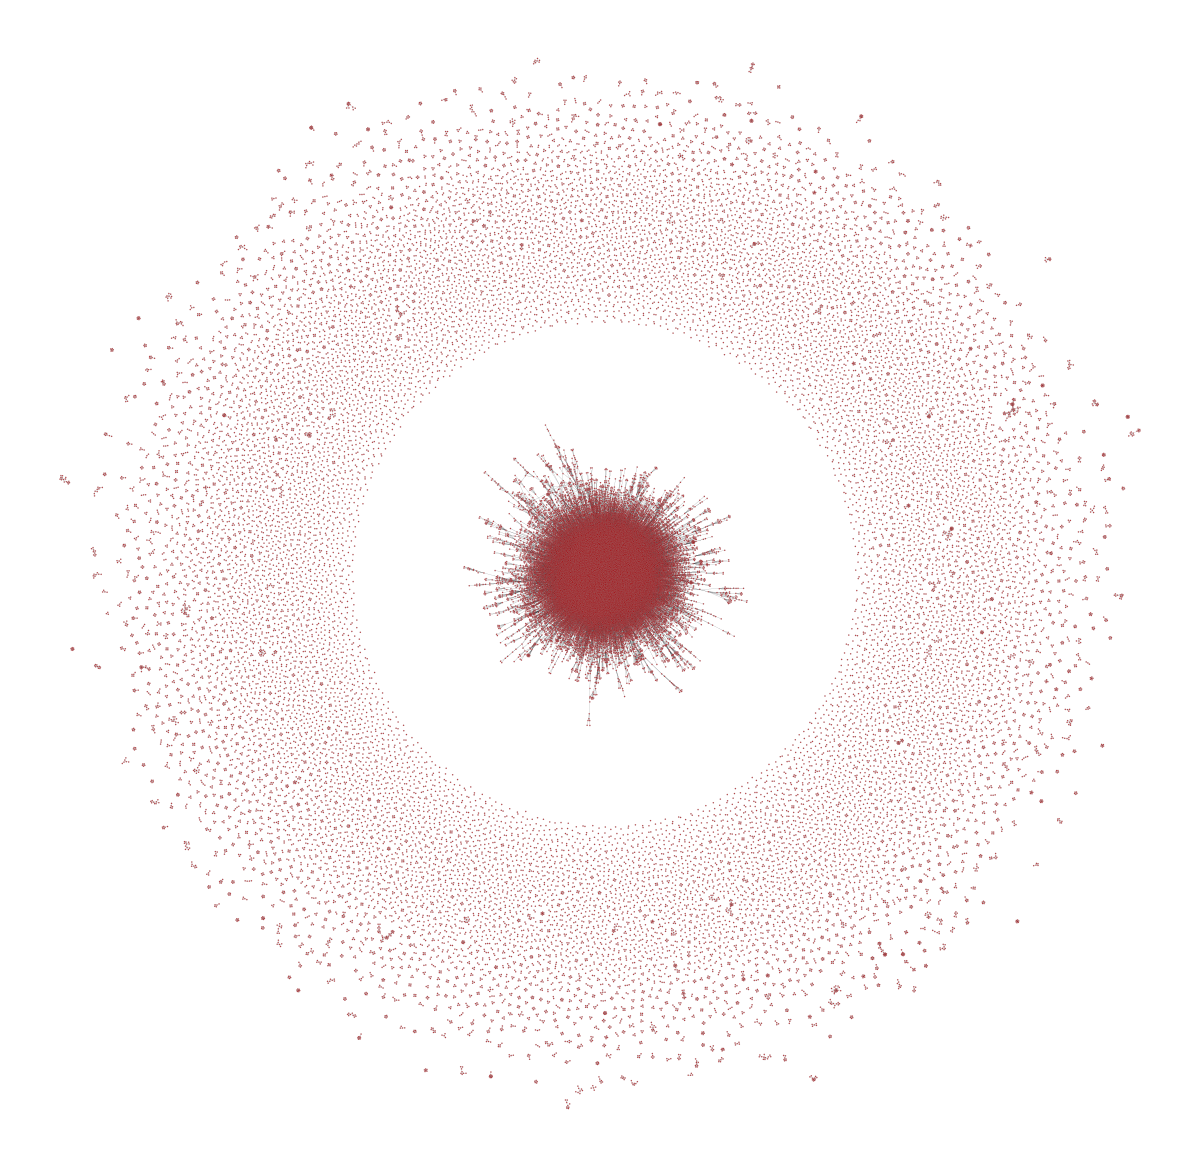

Drawing largest connected component...


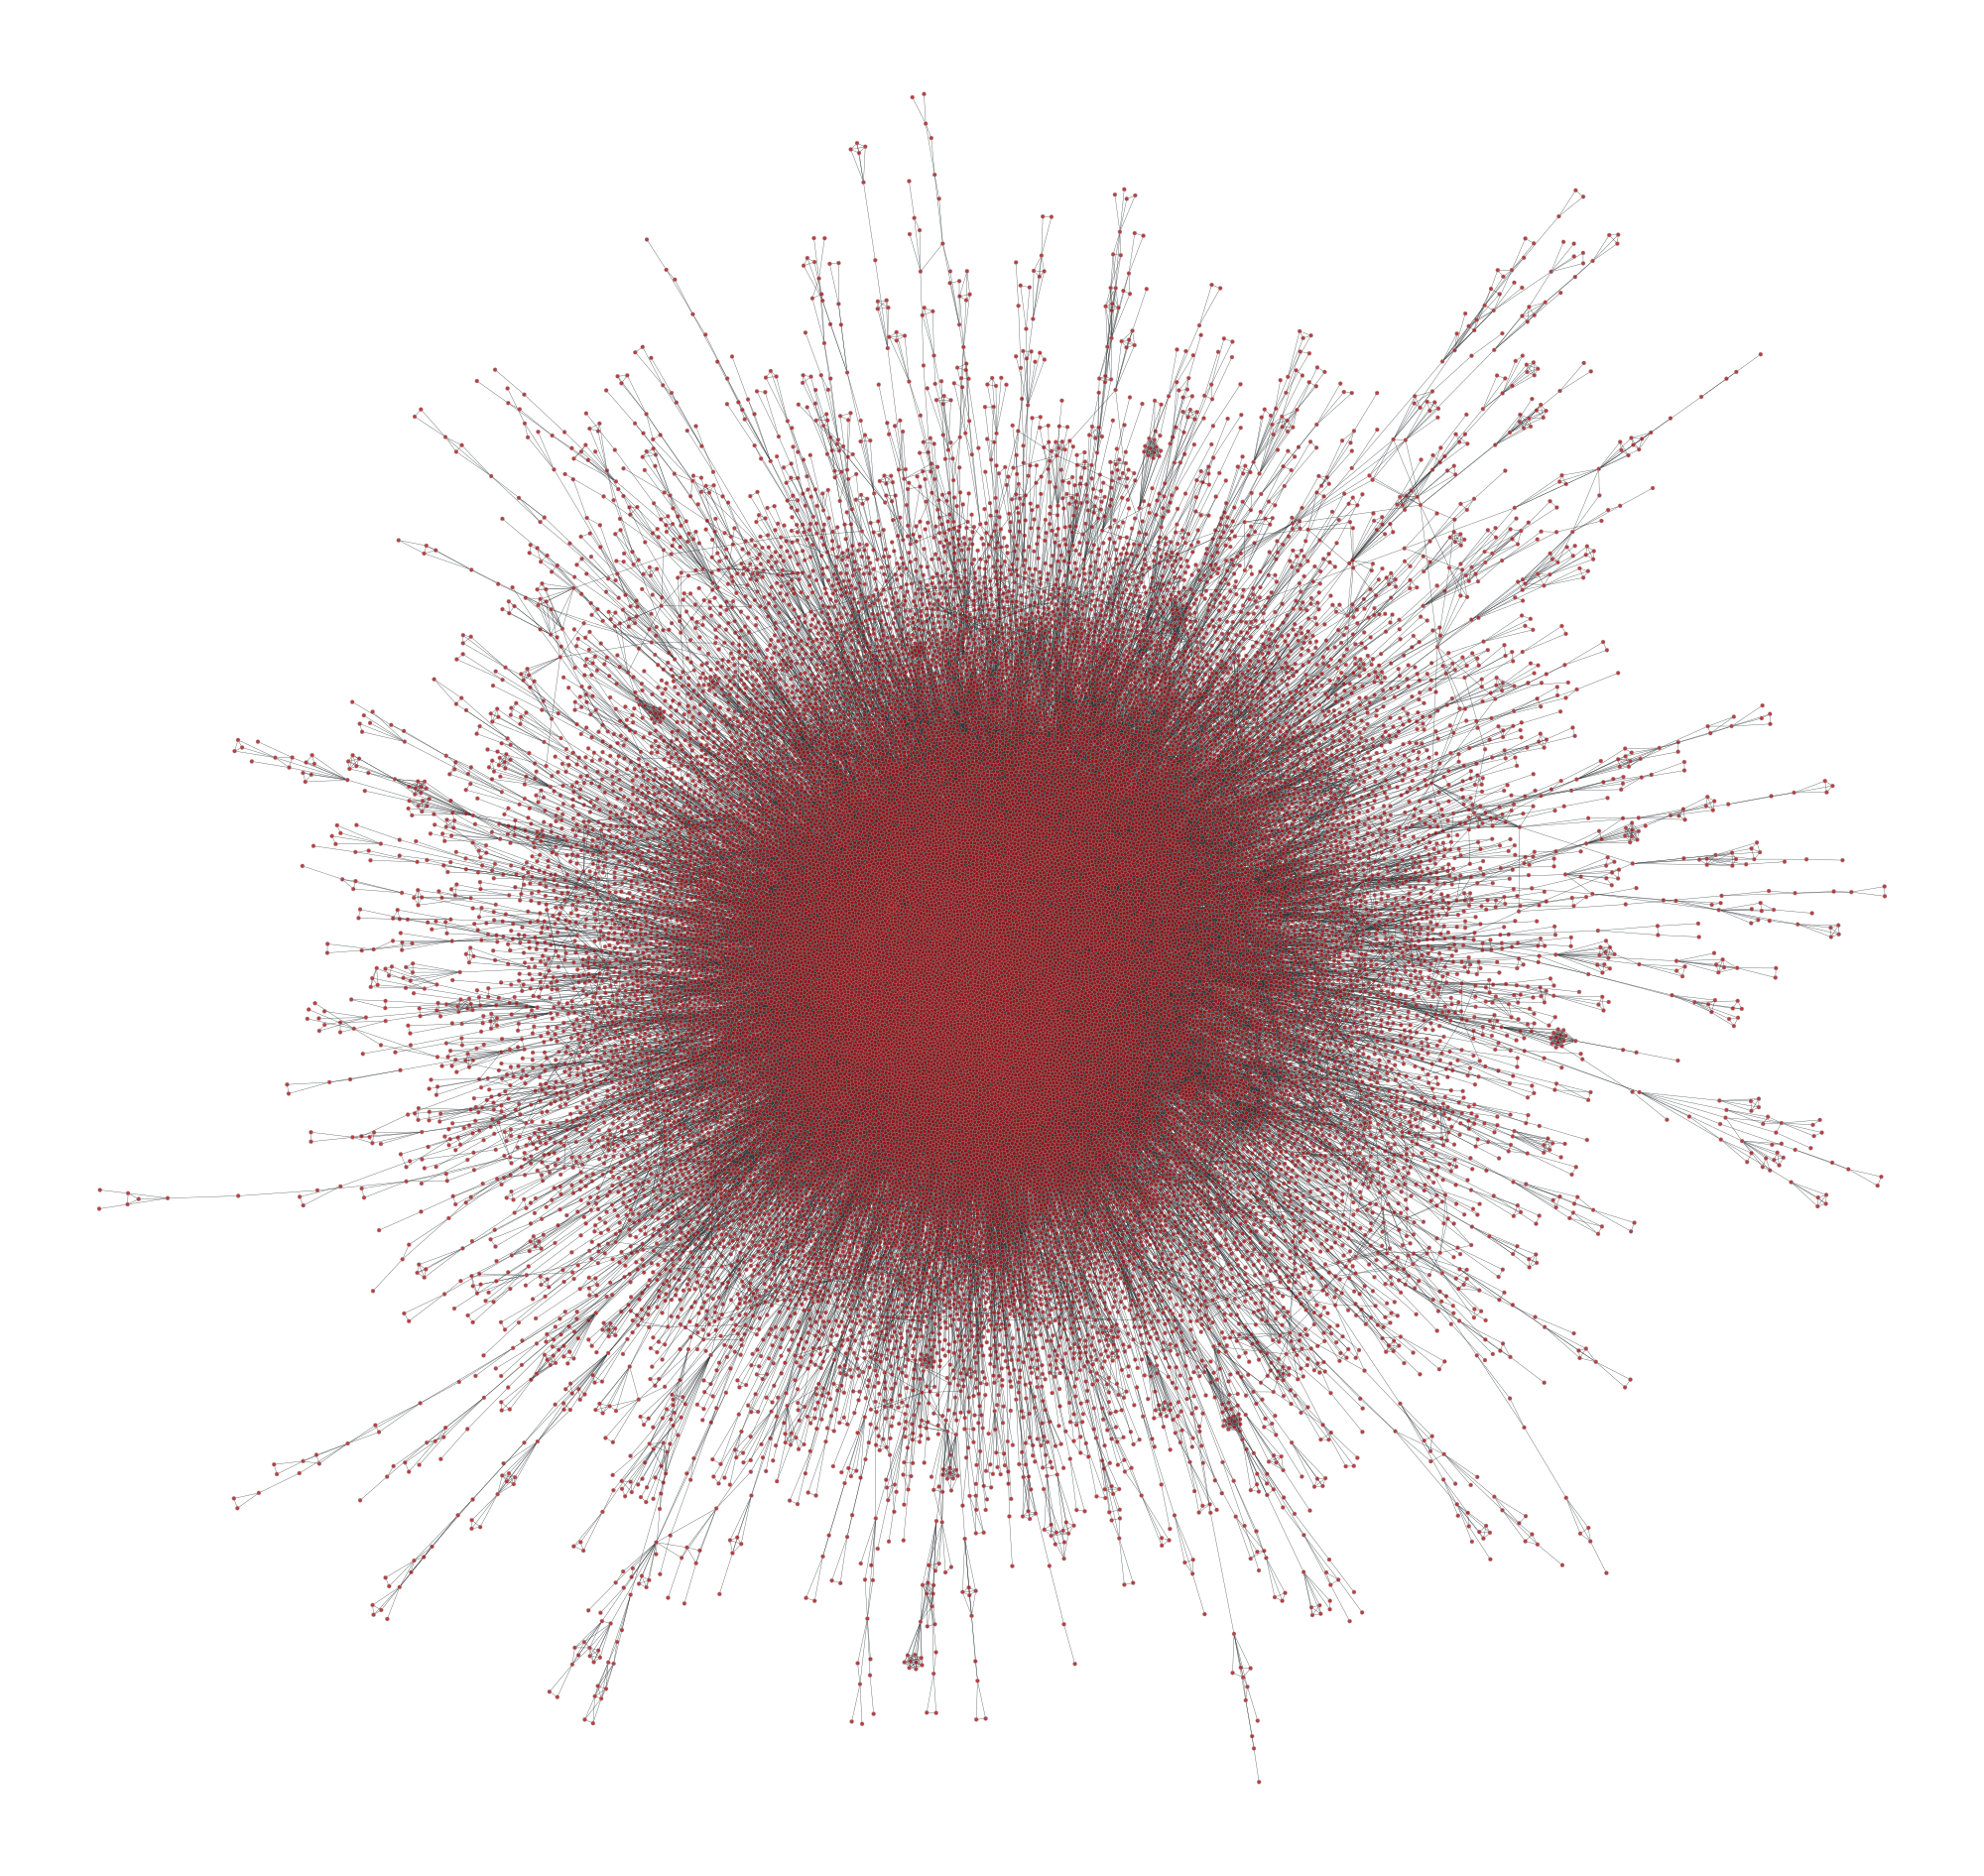

In [13]:
# Create an adjacency matrix from the parsed captions
def create_adj_matrix(parsed_captions, indiv_people):

    print("Creating adjacency matrix...")
    
    # Create empty adj matrix
    adj_matrix = pd.DataFrame(0, indiv_people, indiv_people)

    # Populate adj matrix
    photos = parsed_captions.iloc[:, 3]
    for photo in photos:
        for p1, p2 in itertools.combinations(photo, 2):
            adj_matrix.at[p1, p2] += 1
            adj_matrix.at[p2, p1] += 1

    print("Adjacency matrix populated.")

    return adj_matrix

# Create a networkx graph from the adjacency matrix
def create_graph(adj_matrix):

    graph = nx.from_pandas_adjacency(adj_matrix)

    print("Graph created.")

    return graph

# Visualize the entire graph
def graph_vis_whole(adj_matrix):

    s, t, w = scipy.sparse.find(adj_matrix)

    # Get rid of duplicate edges
    mask = s < t
    s, t, w = s[mask], t[mask], w[mask]

    es = np.array([s, t, w]).T

    g = gt.Graph(adj_matrix.shape[0], directed=False)

    g.add_edge_list(es, eprops=[("weight", "int")])

    print("Drawing full graph...")
    pos = sfdp_layout(g, multilevel=True, gamma=1.5, C=0.8)
    graph_draw(g, pos=pos)

    return g

# Visualize just the largest connected component of the graph
def graph_vis_lcc(g):
    print("Drawing largest connected component...")
    lcc = label_largest_component(g)
    g.set_vertex_filter(lcc)
    g_lcc = gt.GraphView(g, directed=False)

    pos = sfdp_layout(g_lcc, multilevel=True, gamma=1.5, C=0.8)
    graph_draw(g_lcc, pos=pos,
                  output_size=(1000, 1000),
                  vertex_size=2,
                  edge_pen_width=0.2)

# Create adjacency matrix
adj_matrix = create_adj_matrix(parsed, indiv_people)

# Create graph from adj matrix
G = create_graph(adj_matrix)

# Visualize graph
g_vis = graph_vis_whole(adj_matrix)
graph_vis_lcc(g_vis)

## Question 3: Graph EDA (20 p)


- Use parsed names to create the undirected weighted network and visualize it (5 p)

See above! We first visualized the entire graph, and then just the largest connected component to get a better idea of its structure.

- Report the number of nodes and edges (5 p)

In [14]:
n_nodes = G.number_of_nodes()
print("Nodes:", n_nodes)

n_edges = G.number_of_edges()
print("Edges:", n_edges)

Nodes: 58821
Edges: 101857


- What is the diameter of this graph? (5 p) Note: since the graph isn't fully connected, we can't calculate a diameter for the entire graph. So, we just calculated a diameter for the largest connected component. It's pretty darn small for how big the graph is!

In [17]:
components = sorted(nx.connected_components(G), key=len, reverse=True)
largest_cc = components[0]
G_lcc = G.subgraph(largest_cc)
diameter = nx.diameter(G_lcc)
print("Diameter (largest component):", diameter)

Diameter (largest component): 22


- What is the average clustering coeff of the graph? How you interpret this number? (5 p)

In [18]:
avg_clustering = nx.average_clustering(G, weight=None)
print("Average clustering coefficient (weighted):", avg_clustering)

Average clustering coefficient (weighted): 0.49036074885738645


Clustering coefficients range from 0 - 1; we can interpret a coefficient of 0.49 here as indicating that there is a fair amount of clustering in the New York social network. That is, a friend of a friend is often a friend, at least about half the time. This would make sense that we would see some clustering, considering that a social network is one in which there are probably many smaller communities that are tightly clustered (all connected to one another/all take photos with one another) within the larger network.

## Question 4: Graph properties (25 p)

What real-world graph properties does this graph exhibit? Please show your work and interpret your answer. Does the result make sense given the nature of the graph? **See answer below code and visual for degree distribution!**

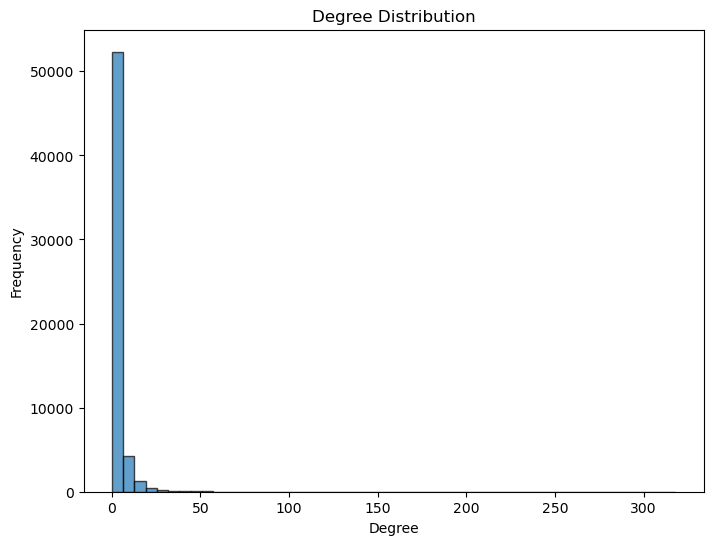

In [20]:
# Plot for degree distribution - yay small world! 
def plot_degree_distribution(G, loglog=False):
    degrees = [d for n, d in G.degree()]
    plt.figure(figsize=(8,6))
    plt.hist(degrees, bins=50, edgecolor="black", alpha=0.7)
    plt.title("Degree Distribution")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    if loglog:
        plt.xscale("log")
        plt.yscale("log")
        plt.title("Degree Distribution (Log-Log Scale)")
    plt.show()

plot_degree_distribution(G)

The party network exhibits several properties common to real-world social graphs. It shows a small-world structure with short paths between individuals (largest connected component with 31,498 nodes has diameter of just 22!). It also seems to be scale-free since the degree distribution (above) seems to follow a power law, suggesting a few highly connected hubs (perhaps frequent party-goers, popular individuals, and organizers) link many others, while most people have relatively few connections. The graph also demonstrates strong community structure, with tightly knit clusters reflecting friend groups who attend parties together, though it is not fully connected, with some individuals or groups remaining isolated. However, the clustering coefficient isn't super close to 1, so presumably the clustering effect is in play: a lot of the nodes with lower degrees (less popular individuals) probably have high clustering coefficients since they mostly go to parties within their smaller communities that are tightly clustered, but there are still enough popular inidividuals with high degrees who have lower clustering coefficients because they connect these smaller communities that aren't themselves connected to bring the average coefficient down a bit to around 0.5. Overall, these properties align well with expectations for a social party network in New York, where hubs, clustering, and communities naturally emerge.

## Question 5: Who are the most photogenic persons? (10 p)

The simplest question to ask is "who is the most popular"?  The easiest way to answer this question is to look at how many connections everyone has.  Return the top 100 people and their degree.  Remember that if an edge of the graph has weight 2, it counts for 2 in the degree.


In [28]:
weighted_degree = dict(G.degree(weight='weight'))
top100_degree = sorted(weighted_degree.items(), key=lambda x: x[1], reverse=True)[:100]

df_top100 = pd.DataFrame(top100_degree, columns=['person','degree'])
print(df_top100.to_string())

                   person  degree
0          Jean Shafiroff     474
1         Mark Gilbertson     281
2     Alexandra Lebenthal     228
3         Gillian Miniter     221
4         Kamie Lightburn     221
5      Geoffrey Bradfield     204
6           Yaz Hernandez     187
7        Eleanora Kennedy     178
8               Alina Cho     177
9           Bonnie Comley     165
10        Debbie Bancroft     162
11          Frick Trustee     161
12            Sharon Bush     156
13           Martha Glass     146
14         Martha Stewart     146
15           Stewart Lane     143
16            Lydia Fenet     142
17           Audrey Gruss     140
18          Somers Farkas     139
19          Allison Aston     137
20          Barbara Tober     129
21         Her Excellency     128
22          Komen Greater     122
23       Margaret Russell     120
24       Deborah Norville     117
25           Diana Taylor     117
26          Jamee Gregory     117
27        Nathalie Kaplan     113
28       Patri

The “most popular” individual in our New York social scene is Jean Shafiroff, a well-known philanthropist ("First-lady of philanthropy"). The second most popular person is Mark Gilbertson, known for his yearly cocktail parties that he hosts. Other notable individuals in the top 10 include:   
  
Alexandra Lebentha (CEO of Lebenthal & Co. (Municipal bond firm)), Gillian Miniter (American bridge player (Silver in world championships)), Kamie Lightburn (Philanthropist and former ballet dancer), Geoffrey Bradfield (South-African interior designer), Yaz Hernandez (Puerto-Rican philanthropist and patron of Latin arts), Eleanora Kennedy (Socialite and philanthropist, known for equestrian events), Alina Cho (Journalist and CNN host), and Bonnie Comley (Tony-award winning producer of Broadway theater).

## Question 6: Centrality analysis (25 p)


Use eccentricity centrality, closeness centrality, betweenness centrality, prestige, and PageRank to identify the top 10 individuals with the highest centrality for each measure. How do you interpret the results?

Use 0.85 as the damping parameter for page rank, so that there is a 15% chance of jumping to another vertex at random.


## Question 7: best_friends (10 p)


Another interesting question is who tend to co-occur with each other.  Give us the 100 edges with the highest weights.

Google these people and see what their connection is.  Can we use this to detect instances of infidelity?


In [32]:
best_friends = []
